# 📈 Growth Investing Lapbook mit Python & Yahoo Finance

Willkommen! In diesem Lapbook entwickeln wir gemeinsam ein Bewertungstool für Wachstumsaktien mit Hilfe der G-R-O-W-T-H-Methode.

Du lernst dabei:

- Aktienkennzahlen mit `yfinance` abzufragen
- Wachstumsfaktoren wie KGV, Umsatzwachstum, PEG zu analysieren
- Visualisierungen mit `matplotlib`
- Bewertungslogik mit einer "Ampel" zu implementieren


📘 Abschnitt 2: Vorbereitung

In [2]:
!pip install yfinance streamlit matplotlib pandas --quiet

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

📘 Abschnitt 3: Aktienauswahl und Stammdaten

## 🔍 Schritt 1: Aktie auswählen

Hier musst Du das Tickersmybol der Aktie eintragen. Die Tickersymbole sind in der CSV-Datei tickers.csv gespeichert.

In [15]:
ticker_symbol = "MSFT"

📘 Abschnitt 4: Fundamentaldaten laden

In [16]:
# Daten abrufen
stock = yf.Ticker(ticker_symbol)
info = stock.info
financials = stock.financials
balance = stock.balance_sheet

# Basisdaten
name = info.get("shortName", "Unbekannt")
currency = info.get("currency", "USD")
current_price = stock.history(period="1d")["Close"].iloc[-1]


📘 Abschnitt 5: Wachstum & Kennzahlen berechnen

In [17]:
# EPS, KGV, fairer Preis
eps = info.get("trailingEps", None)
pe_ratio = info.get("forwardPE", None)
fair_price = eps * pe_ratio if eps and pe_ratio else None

# PEG berechnen
eps_forward = info.get("forwardEps", None)
peg_ratio = None
if eps and eps_forward and eps > 0:
    eps_growth = (eps_forward - eps) / eps * 100
    peg_ratio = pe_ratio / eps_growth if eps_growth != 0 else None


📘 Abschnitt 6: Visualisierung mit Chart

[*********************100%***********************]  1 of 1 completed


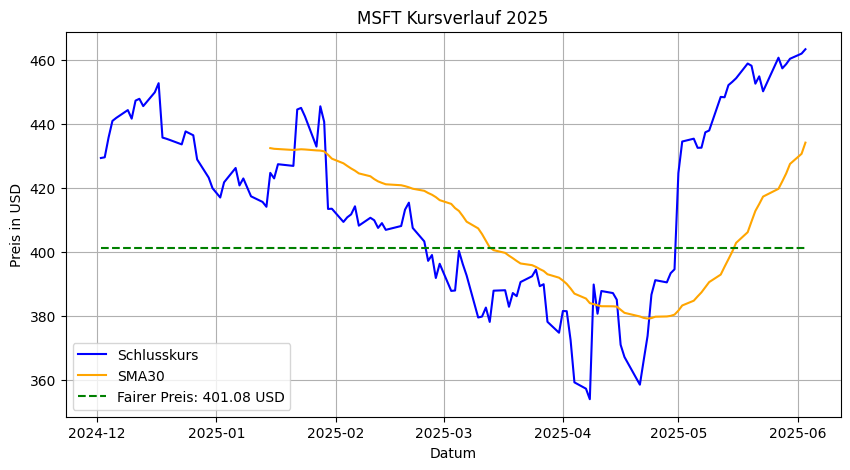

In [18]:
# Chartdaten
start_date = datetime(datetime.now().year, 1, 1)
end_date = datetime.now()
stock_data = yf.download(ticker_symbol, start=start_date - timedelta(days=30), end=end_date)
sma30 = stock_data['Close'].rolling(window=30).mean()
fair_price_series = pd.Series(fair_price, index=stock_data.index)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stock_data.index, stock_data['Close'], label='Schlusskurs', color='blue')
plt.plot(sma30, label='SMA30', color='orange')
if fair_price:
    plt.plot(fair_price_series, label=f'Fairer Preis: {fair_price:.2f} {currency}', linestyle='--', color='green')
plt.title(f'{ticker_symbol} Kursverlauf {start_date.year}')
plt.xlabel("Datum")
plt.ylabel(f"Preis in {currency}")
plt.grid()
plt.legend()
plt.show()

📘 Abschnitt 7: G-R-O-W-T-H Ampel

In [19]:
# Ampelfunktion
def ampel(wert, gelb, gruen):
    if wert is None:
        return "❓"
    elif wert > gruen:
        return "🟢"
    elif wert > gelb:
        return "🟡"
    else:
        return "🔴"

In [20]:
# G: Wachstum
growth_rate = info.get("forwardEps", None)
# R: Analystenmeinung
rating = info.get("recommendationKey", None)
ra = 1 if rating in ["buy", "strong_buy"] else 0.5 if rating == "hold" else 0
# O: operative Marge
operating_margin = info.get("operatingMargins", None)
# W: Vermögenswachstum (Umsatz)
total_revenue = financials.loc["Total Revenue"][::-1]
wealth_growth = total_revenue.pct_change().iloc[-1]
# T: Verschuldung
total_debt = balance.loc["Total Debt"].iloc[0]
total_assets = balance.loc["Total Assets"].iloc[0]
debt_ratio = total_debt / total_assets if total_assets > 0 else None
# H: Historisches Wachstum
hist = stock.history(period="5y")["Close"]
cagr = (hist.iloc[-1] / hist.iloc[0]) ** (1/5) - 1 if not hist.empty else None


/tmp/ipykernel_132/664113839.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wealth_growth = total_revenue.pct_change().iloc[-1]


📘 Abschnitt 8: Bewertungstabelle & Export

In [21]:
# Bewertungstabelle
df_bewertung = pd.DataFrame({
    "Kriterium": ["Wachstum", "Rating", "Operative Marge", "Umsatzwachstum", "Verschuldung", "Historisches Wachstum"],
    "Wert": [
        f"{growth_rate:.2f}" if growth_rate else "n/a",
        rating,
        f"{operating_margin:.2f}" if operating_margin else "n/a",
        f"{wealth_growth:.2f}" if wealth_growth else "n/a",
        f"{debt_ratio:.2f}" if debt_ratio else "n/a",
        f"{cagr:.2f}" if cagr else "n/a"
    ],
    "Ampel": [
        ampel(growth_rate, 5, 15),
        ampel(ra, 0.4, 0.9),
        ampel(operating_margin, 0.1, 0.2),
        ampel(wealth_growth, 0.03, 0.1),
        ampel(1 - debt_ratio if debt_ratio else None, 0.4, 0.7),
        ampel(cagr, 0.05, 0.12)
    ]
})

df_bewertung

,Kriterium,Wert,Ampel
0,Wachstum,14.95,🟡
1,Rating,strong_buy,🟢
2,Operative Marge,0.46,🟢
3,Umsatzwachstum,0.16,🟢
4,Verschuldung,0.13,🟢
5,Historisches Wachstum,0.21,🟢
